In [1]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from sklearn_pandas import DataFrameMapper
    from sklearn import metrics
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.decomposition import PCA
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from sklearn.linear_model import LinearRegression, Lasso, Ridge
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import RandomForestRegressor
    import warnings
    print("Se importó correctamente")
except Exception as e:
    print(f"Error al importar dependencias: {e}")

Se importó correctamente


* Al tener el Data Set repartido en 4 archivos diferentes segun la plataforma donde se produjeron las ventas, paso a unificar todo en un mismo DataFrame

In [2]:
import pandas as pd
import os

# Ruta a la carpeta que contiene los archivos
ruta_carpeta = "./csv"

# Lista de archivos que deseas concatenar
archivos_csv = ["fravega.csv", "ecommerce.csv", "mercadolibre.csv", "megatone.csv"]

# Leer los archivos con el delimitador adecuado y almacenarlos en una lista de DataFrames
dfs = [pd.read_csv(os.path.join(ruta_carpeta, archivo), encoding='latin1', delimiter=';') for archivo in archivos_csv]

# Concatenar los DataFrames en uno solo
sales = pd.concat(dfs, ignore_index=True)

sales.sample(5)

,VALOR PRED.,ORDEN DE RETIRO,FECHA RETIRO OCA,COD. PRODUCTO,CANTIDAD,PRODUCTO,DTO %,FECHA COMPRA,PROVINCIA,LOCALIDAD,PLATAFORMA
3040,1.0,NaN,26/8/2022,1-15-36-003,1.0,NaN,NaN,22/8/2022,BUENOS AIRES,Tres Arroyos,mercadolibre
594,1,ANDREANI,11/9/2023,1-23-15-006,1,PROMO 2 CONJUNTOS L. DALI TRADICIONAL 100CMX190CM,0,1/9/2023,BUENOS AIRES,Mar Del Plata,fravega
10957,1,109433640,NaN,NaN,1.0,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,4,12/8/2023,TUCUMÁN,LAS TALITAS,megatone
2804,1.0,98404450,9/6/2022,1-23-15-004,1.0,NaN,NaN,8/6/2022,SANTA CRUZ,Caleta Olivia,mercadolibre
10246,1,106329383,NaN,NaN,1.0,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,4,28/4/2023,SANTA FE,ROSARIO,megatone


## Listado de variables 

#### Variables de entrada

* VALOR PRED.: Representa el valor del bulto.
* ORDEN DE RETIRO: Nro de orden por la cual la empresa identifica cada venta
* FECHA RETIRO OCA: Fecha donde OCA retira el producto
* COD. PRODUCTO: Identificador único de cada producto.
* PRODUCTO: Descripción del producto
* DTO %: Descuento aplicado en cada venta.
* FECHA COMPRA: Fecha en la que se realizó la compra del producto
* PROVINCIA: Nombre de la provincia donde se produjo de la venta
* LOCALIDAD: Nombre de la localidad donde se produjo de la venta
* PLATAFORMA: Canal o medio donde se produjo la venta.

#### Variable de salida: 

* CANTIDAD: representa el número de unidades vendidas por producto

#### Reorganizo las columnas en el orden deseado

In [3]:
orden_columnas = [
    'VALOR PRED.', 'ORDEN DE RETIRO', 'FECHA COMPRA', 'FECHA RETIRO OCA','COD. PRODUCTO', 'PRODUCTO', 'DTO %', 'PROVINCIA', 'LOCALIDAD', 'PLATAFORMA',
    'CANTIDAD'
]

# Reorganizar el DataFrame
sales = sales[orden_columnas]

# Mostrar las primeras filas del DataFrame reorganizado
print("Columnas reorganizadas:")
sales.sample(5)

Columnas reorganizadas:


,VALOR PRED.,ORDEN DE RETIRO,FECHA COMPRA,FECHA RETIRO OCA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
7578,1,93508715,8/11/2021,11/11/2021,NaN,COLCHÓN L. HARTMANN TRADICIONAL 140CMX190CM,0,LA RIOJA,CHAMICAL,megatone,1.0
6216,1.0,NaN,9/6/2023,23/6/2023,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,NaN,CAPITAL FEDERAL,Palermo,mercadolibre,1.0
1743,NaN,NaN,3/11/2021,NaN,NaN,ALMOHADAS L.VISCOÉLASTICA 70CM,NaN,SANTA FE,Rafaela,ecommerce,1
6119,1.0,106915365,15/5/2023,22/5/2023,1-15-37-006,CONJUNTO L. VASARI TRADICIONAL 140CMX190CM,NaN,BUENOS AIRES,Tandil,mercadolibre,1.0
8526,1,98393113,8/6/2022,10/6/2022,1-10-02-002,ALMOHADAS L.PLACA 80CM,NaN,BUENOS AIRES,PILAR,megatone,1.0


## Análisis detallado de un conjunto de variables

La variable CANTIDAD representa el número de unidades vendidas. Es la variable objetivo de este análisis, ya que el modelo buscará predecir su valor en función de las características del dataset.

Predecir CANTIDAD permitirá:

* Identificar tendencias de venta.
* Optimizar la planificación de inventarios.
* Mejorar la estrategia de ventas y promociones.

### Estadísticas descriptivas de la variable de salida

In [4]:
print("Estadísticas descriptivas de 'CANTIDAD':")
print(sales['CANTIDAD'].describe())

Estadísticas descriptivas de 'CANTIDAD':
count     11103
unique       15
top           1
freq       8976
Name: CANTIDAD, dtype: int64


In [5]:
# Convierto la columna 'CANTIDAD' a numérico, convirtiendo valores no válidos a NaN
sales['CANTIDAD'] = pd.to_numeric(sales['CANTIDAD'], errors='coerce')
# Reemplazo los valores NaN con 1
sales['CANTIDAD'] = sales['CANTIDAD'].fillna(1)
# Convierto la columna a enteros
sales['CANTIDAD'] = sales['CANTIDAD'].astype(int)

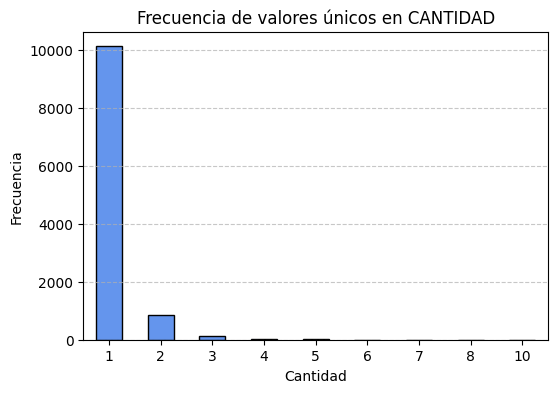

In [6]:
# Frecuencia de valores únicos en 'CANTIDAD'
frecuencia_cantidad = sales['CANTIDAD'].value_counts().sort_index()

# Gráfico de barras
plt.figure(figsize=(6, 4))
frecuencia_cantidad.plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title('Frecuencia de valores únicos en CANTIDAD', fontsize=12)
plt.xlabel('Cantidad', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



## EDA, Limpieza y preprocesamiento

* Verificación de valores nulos en variable COD PRODUCTO y PRODUCTO:

In [8]:
# Contar nulos y valores vacíos en 'COD. PRODUCTO'
nulos_o_vacios_cod_producto = sales['COD. PRODUCTO'].isna().sum() + sales['COD. PRODUCTO'].eq('').sum()

# Contar nulos y valores vacíos en 'PRODUCTO'
nulos_o_vacios_producto = sales['PRODUCTO'].isna().sum() + sales['PRODUCTO'].str.strip().eq('').sum()

print(f"Valores nulos o vacíos en 'COD. PRODUCTO': {nulos_o_vacios_cod_producto}")
print(f"Valores nulos o vacíos en 'PRODUCTO': {nulos_o_vacios_producto}")

Valores nulos o vacíos en 'COD. PRODUCTO': 3298
Valores nulos o vacíos en 'PRODUCTO': 2198


- Tratamiento para determinar que para algunos de los COD PRODUCTOS detectados sin descripcion de Producto tenga en algun otro lado del data set la descripcion. Lo mismo para aquellas Productos detectados sin Cod Producto. 
El objetivo de esto es rellenar valores que se detectan nulos en las columnas de COD PRODUCTO y PRODUCTO.

In [9]:
# Crear un mapeo único entre COD PRODUCTO y PRODUCTO
mapeo_cod_producto = sales[['COD. PRODUCTO', 'PRODUCTO']].drop_duplicates()

print("Mapa único entre códigos y productos:")
mapeo_cod_producto.shape

Mapa único entre códigos y productos:


(478, 2)

In [10]:
# Convertir el mapeo a un diccionario para facilitar su uso
mapeo_dict = mapeo_cod_producto.set_index('PRODUCTO')['COD. PRODUCTO'].to_dict()

# Completar o corregir la columna 'COD PRODUCTO'
sales['COD. PRODUCTO'] = sales['PRODUCTO'].map(mapeo_dict)

In [11]:
# Detectar inconsistencias entre 'COD PRODUCTO' y 'PRODUCTO'
inconsistencias = sales[sales['PRODUCTO'] != sales['COD. PRODUCTO'].map(mapeo_dict)]

In [12]:
sales['PRODUCTO'] = sales['COD. PRODUCTO'].map({v: k for k, v in mapeo_dict.items()})


In [13]:
sales.sample(5)

,VALOR PRED.,ORDEN DE RETIRO,FECHA COMPRA,FECHA RETIRO OCA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
572,1,Rayo,28/8/2023,30/8/2023,NaN,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0,BUENOS AIRES,Merlo,fravega,1
1134,1,91088603,27/7/2021,4/8/2021,NaN,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,"$ 0,00",BUENOS AIRES,Carmen de Patagones,ecommerce,1
2723,1.0,98298163,3/6/2022,9/6/2022,1-11-16-017,NaN,10.0,MENDOZA,6ta sección de Cuidad,mercadolibre,1
7141,1,90146965,16/6/2021,23/6/2021,1-14-11-006,CONJUNTO L. ATENAS TRADICIONAL 140CMX190CM,0,CÓRDOBA,LAS ARRIAS,megatone,1
6270,1.0,NaN,15/6/2023,23/6/2023,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,NaN,CHUBUT,Comodoro Rivadavia,mercadolibre,1


In [14]:
faltantes_codproducto = sales[sales['COD. PRODUCTO'].isna()]
# Obtener los valores únicos de la columna 'PRODUCTO'
valores_unicos_producto = faltantes_codproducto['PRODUCTO'].unique()

print(valores_unicos_producto)

['CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM']


In [15]:
productos_con_nan = sales[sales['COD. PRODUCTO'].isna()]

# Mostrar valores únicos de la columna 'PRODUCTO' donde 'COD PRODUCTO' es NaN
valores_producto_nan = productos_con_nan['PRODUCTO'].unique()

print("Valores únicos en la columna 'PRODUCTO' donde 'COD PRODUCTO' es NaN:")
print(valores_producto_nan)

Valores únicos en la columna 'PRODUCTO' donde 'COD PRODUCTO' es NaN:
['CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM']


In [16]:
sales.loc[sales['COD. PRODUCTO'].isna(), 'COD. PRODUCTO'] = '1-20-20-200'

In [17]:
sales.sample(2)

,VALOR PRED.,ORDEN DE RETIRO,FECHA COMPRA,FECHA RETIRO OCA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
948,1,90063726,12/6/2021,18/6/2021,1-14-15-002,CONJUNTO L. DALI TRADICIONAL 80CMX190CM,"$ 0,00",SALTA,TARTAGAL,ecommerce,1
1861,1,93574367,10/11/2021,11/11/2021,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,NaN,RÍO NEGRO,VIEDMA,ecommerce,1


* Verificamos si quedan filas donde 'COD PRODUCTO' es nulo

In [18]:
sin_codproducto = sales[sales['COD. PRODUCTO'].isna()]
print("Filas con 'COD PRODUCTO' faltante:")
sin_codproducto.shape

Filas con 'COD PRODUCTO' faltante:


(0, 11)

In [19]:
# Mostrar filas donde 'PRODUCTO' es NaN
sin_producto = sales[sales['PRODUCTO'].isna()]
print("Filas con 'PRODUCTO' faltante:")
sin_producto.shape

Filas con 'PRODUCTO' faltante:


(2212, 11)

In [20]:
# Contar valores únicos en 'COD. PRODUCTO'
valores_unicos_cod_producto = sin_producto['COD. PRODUCTO'].unique()

# Contar la cantidad de valores únicos
cantidad_valores_unicos = len(valores_unicos_cod_producto)
print(valores_unicos_cod_producto)

['1-11-16-017']


In [21]:
sales.loc[sales['PRODUCTO'].isna() , 'PRODUCTO'] = 'ALMOHADAS M.COPO 90CM'

In [22]:
# Contar valores nulos en cada columna
valores_nulos = sales.isna().sum()

print("Cantidad de valores nulos por columna:")
print(valores_nulos)

Cantidad de valores nulos por columna:
VALOR PRED.          254
ORDEN DE RETIRO     3852
FECHA COMPRA          40
FECHA RETIRO OCA    1104
COD. PRODUCTO          0
PRODUCTO               0
DTO %               6457
PROVINCIA             57
LOCALIDAD            247
PLATAFORMA             0
CANTIDAD               0
dtype: int64


* Limpieza y correccion de valores en las columnas. 

In [23]:
# Asignar el valor de 'PROVINCIA' a 'LOCALIDAD' donde 'LOCALIDAD' es nulo
sales['LOCALIDAD'] = sales['LOCALIDAD'].fillna(sales['PROVINCIA'])

# Asignar 'Descripcion faltante' donde 'COD. PRODUCTO' sea NaN
sales['COD. PRODUCTO'] = sales['COD. PRODUCTO'].fillna('Descripcion faltante')

#Convertir la columna 'DTO' a valores enteros
sales['DTO %'] = sales['DTO %'].replace(['$0,00', 0.0], '0').fillna('0')

In [24]:
# Verificar valores nulos restantes en todo el dataset
print("Valores nulos restantes por columna:")
print(sales.isna().sum())

Valores nulos restantes por columna:
VALOR PRED.          254
ORDEN DE RETIRO     3852
FECHA COMPRA          40
FECHA RETIRO OCA    1104
COD. PRODUCTO          0
PRODUCTO               0
DTO %                  0
PROVINCIA             57
LOCALIDAD             57
PLATAFORMA             0
CANTIDAD               0
dtype: int64


In [25]:
# Eliminar las columnas que no voy a utilizar
sales = sales.drop(columns=['VALOR PRED.', 'ORDEN DE RETIRO', 'FECHA RETIRO OCA'])
# Eliminar filas donde 'PROVINCIA' sea NaN
sales = sales.dropna(subset=['PROVINCIA'])
# Convertir la columna 'CANTIDAD' a enteros
sales['CANTIDAD'] = sales['CANTIDAD'].astype(int)
# Convertir la columna 'DTO %' a tipo numérico para reemplazar los valores que no son % de descuento sino monto en pesos
sales['DTO %'] = pd.to_numeric(sales['DTO %'], errors='coerce')
# Reemplazar valores de DTO % fuera del rango (negativos o mayores a 50) y nulos con 0
sales['DTO %'] = sales['DTO %'].apply(lambda x: 0 if pd.isna(x) or x > 50 or x < 0 else x)


In [26]:
# Eliminar filas donde 'FECHA COMPRA' sea NaN, REVISAR para buscar la fecha 
sales = sales.dropna(subset=['FECHA COMPRA'])

In [27]:
sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], errors='coerce')

sales['FECHA COMPRA'] = sales['FECHA COMPRA'].ffill()  # Rellenar con el valor anterior
sales['FECHA COMPRA'] = sales['FECHA COMPRA'].bfill()  # Si no hay anterior, usar el siguiente

sales = sales.sort_values(by='FECHA COMPRA')

C:\Users\bosch\AppData\Local\Temp\ipykernel_27812\3226930836.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], errors='coerce')


In [28]:
sales.sample(5)

,FECHA COMPRA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
9041,2022-08-23,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,BUENOS AIRES,CAPITAL FEDERAL,megatone,1
7164,2021-07-02,1-12-40-002,COLCHÓN L. ROMA TRADICIONAL 80CMX190CM,5.0,CÓRDOBA,CÓRDOBA,megatone,1
4336,2022-12-21,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,CÓRDOBA,Valle Hermoso,mercadolibre,1
2614,2022-05-30,1-11-16-017,ALMOHADAS M.COPO 90CM,10.0,CHUBUT,Comodoro Rivadavia,mercadolibre,1
2732,2022-06-03,1-11-16-017,ALMOHADAS M.COPO 90CM,15.0,SANTA FE,Rosario,mercadolibre,1


In [29]:
# Verificar valores nulos restantes en todo el dataset
print("Valores nulos restantes por columna:")
print(sales.isna().sum())

Valores nulos restantes por columna:
FECHA COMPRA     0
COD. PRODUCTO    0
PRODUCTO         0
DTO %            0
PROVINCIA        0
LOCALIDAD        0
PLATAFORMA       0
CANTIDAD         0
dtype: int64


## A modo resumen un detalle de las transformaciones realizadas a las variables 

* Valor Pred : Eliminada ya que no aporta valor al modelo
* Orden de Retiro : Eliminada ya que no aporta valor al modelo, es un identificador de la venta
* Fecha retiro OCA: Eliminada ya que no aporta valor al modelo
* Fecha compra : El data set inical estaba ordenado por fecha, cuando algun registro no contaba con la misma se buscó insertar la mas cercana en el índice anterior.
* Cantidad: se convirtió a valor entero en todos sus casos.
* Cod. Producto: se rellenó los valores faltantes comparando la descripcion del producto en otras celdas que tenga el cod producto cargado.
* Producto: se rellenó los valores faltantes comparando el cod. producto en otras celdas que tenga la misma descripción del producto cargada. 
* DTO %: Algunos registros no tenian valor porcentual sino numérico, por lo que cuando se encontraba un valor mayor a 50 se insertó 0.
* Localidad: Se rellenó para los valores faltantes con el nombre de la provincia como valor genérico, posiblemente no aporte mucho valor al modelo.
* Provincia: Se eliminaron los registros que no contaban con provincia asignada


## Realizar un análisis individual de cada variable de entrada que será utilizada. A partir del mismo debería poder conocerse la distribución de los datos, si existen valores raros, su relación con la variable de salida, etc.

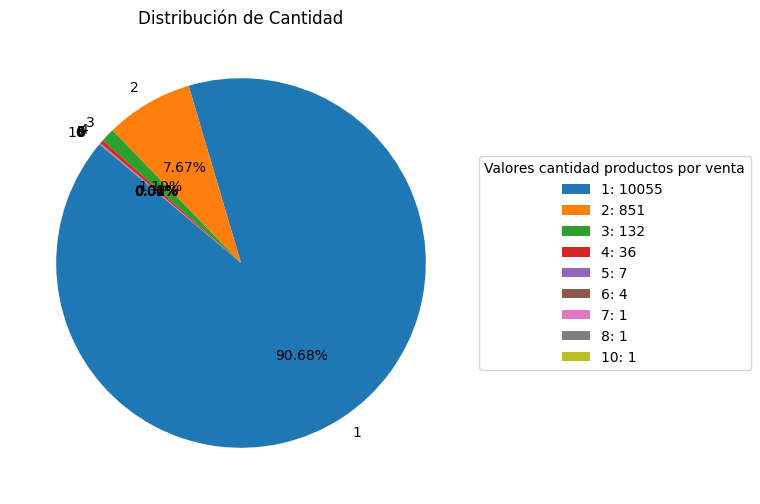

In [30]:
import matplotlib.pyplot as plt

# Filtrar valores no nulos y calcular frecuencia
cantidad_frecuencia = sales['CANTIDAD'].value_counts()

plt.figure(figsize=(6, 6))  # Ajustar tamaño del gráfico
wedges, texts, autotexts = plt.pie(
    cantidad_frecuencia, 
    labels=cantidad_frecuencia.index, 
    autopct='%2.2f%%', 
    startangle=140
)
leyenda = [f"{index}: {value} " for index, value in cantidad_frecuencia.items()]
plt.legend(
    wedges, 
    leyenda, 
    title="Valores cantidad productos por venta", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title('Distribución de Cantidad')
plt.show()



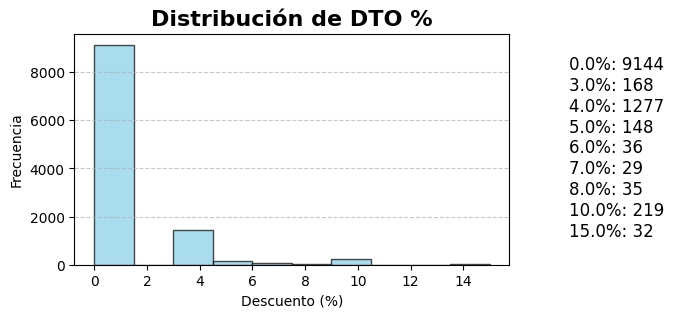

In [31]:
dto_frecuencia = sales['DTO %'].value_counts().sort_index()

plt.figure(figsize=(6, 3))
plt.hist(sales['DTO %'], bins=10, edgecolor='black', color='skyblue', alpha=0.7)
plt.title('Distribución de DTO %', fontsize=16, fontweight='bold')
plt.xlabel('Descuento (%)', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

frecuencias_texto = "\n".join([f"{index}%: {value}" for index, value in dto_frecuencia.items()])
plt.gcf().text(0.95, 0.5, frecuencias_texto, fontsize=12, verticalalignment='center')
plt.subplots_adjust(right=0.85)

plt.show()

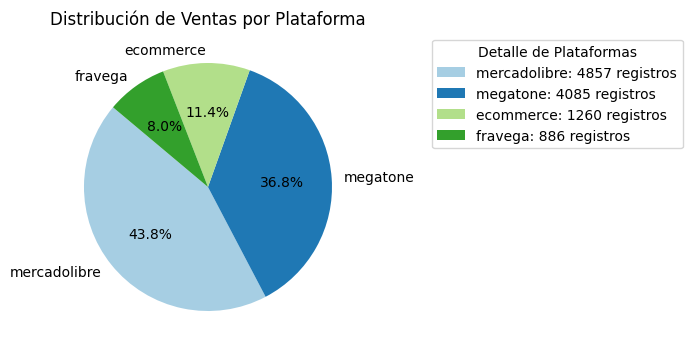

In [32]:
frecuencia_plataforma = sales['PLATAFORMA'].value_counts()

plt.figure(figsize=(4, 8))
plt.pie(
    frecuencia_plataforma,
    labels=frecuencia_plataforma.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title('Distribución de Ventas por Plataforma', fontsize=12)
plt.legend(
    labels=[f"{index}: {value} registros" for index, value in frecuencia_plataforma.items()],
    title="Detalle de Plataformas",    
    loc="center left",
    bbox_to_anchor=(1.2, 0.8)  
)

plt.show()

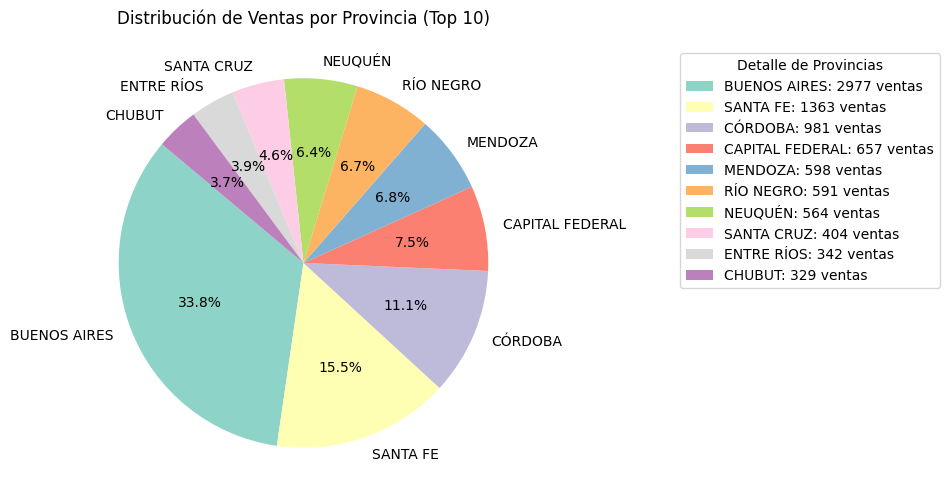

In [33]:
frecuencia_provincia = sales['PROVINCIA'].value_counts().head(10)

plt.figure(figsize=(6, 6))
plt.pie(
    frecuencia_provincia,
    labels=frecuencia_provincia.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
plt.title('Distribución de Ventas por Provincia (Top 10)', fontsize=12)
plt.legend(
    labels=[f"{index}: {value} ventas" for index, value in frecuencia_provincia.items()],
    title="Detalle de Provincias",
    loc="center left", 
    bbox_to_anchor=(1.3, 0.7) 
)

plt.show()


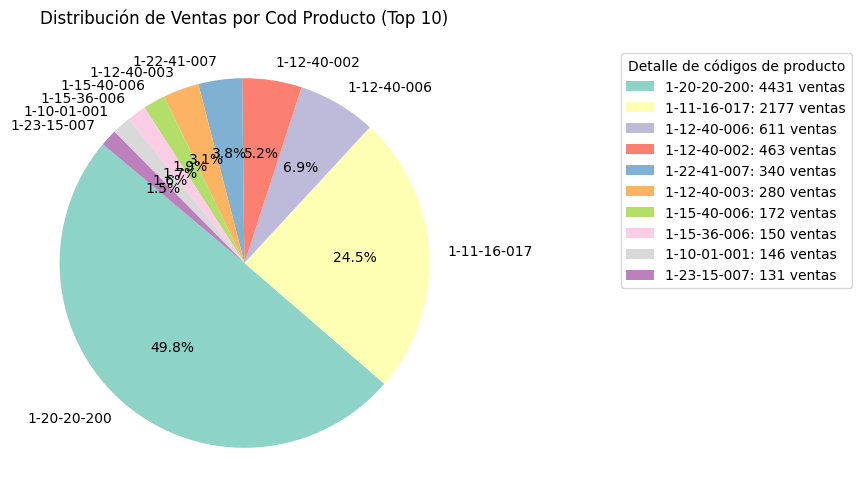

In [34]:
frecuencia_provincia = sales['COD. PRODUCTO'].value_counts().head(10)

plt.figure(figsize=(6, 6))
plt.pie(
    frecuencia_provincia,
    labels=frecuencia_provincia.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
plt.title('Distribución de Ventas por Cod Producto (Top 10)', fontsize=12)
plt.legend(
    labels=[f"{index}: {value} ventas" for index, value in frecuencia_provincia.items()],
    title="Detalle de códigos de producto",
    loc="center left", 
    bbox_to_anchor=(1.3, 0.7) 
)

plt.show()

## Transformaciones Fecha Compra

In [35]:
# Convertir 'FECHA COMPRA' a datetime especificando el formato exacto
sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], format='%d/%m/%Y')

In [36]:
# Crear columnas temporales
sales['AÑO'] = sales['FECHA COMPRA'].dt.year
sales['MES'] = sales['FECHA COMPRA'].dt.month

sales.sample(10)

,FECHA COMPRA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD,AÑO,MES
8053,2022-03-29,1-12-40-003,COLCHÓN L. ROMA TRADICIONAL 90CMX190CM,0.0,JUJUY,SAN SALVADOR DE JUJUY,megatone,2,2022,3
5613,2023-05-09,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,CHUBUT,Trelew,mercadolibre,1,2023,5
1249,2021-08-25,1-15-36-006,CONJUNTO L. SANZIO TRADICIONAL 140CMX190CM,0.0,BUENOS AIRES,Henderson,ecommerce,1,2021,8
5410,2023-05-07,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,BUENOS AIRES,La Plata,mercadolibre,1,2023,5
1154,2021-08-04,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,SANTA FE,Cañada de gomez,ecommerce,1,2021,8
7210,2021-07-19,1-12-40-002,COLCHÓN L. ROMA TRADICIONAL 80CMX190CM,5.0,BUENOS AIRES,HURLINGHAM,megatone,1,2021,7
7780,2022-01-06,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,0.0,BUENOS AIRES,CASTELAR,megatone,1,2022,1
2966,2022-07-03,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,NEUQUÉN,Villa La Angostura,mercadolibre,1,2022,7
6920,2024-01-06,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,CÓRDOBA,Morteros,mercadolibre,1,2024,1
5730,2023-05-10,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,0.0,CAPITAL FEDERAL,Abasto,mercadolibre,1,2023,5


* Distribucion de ventas por mes

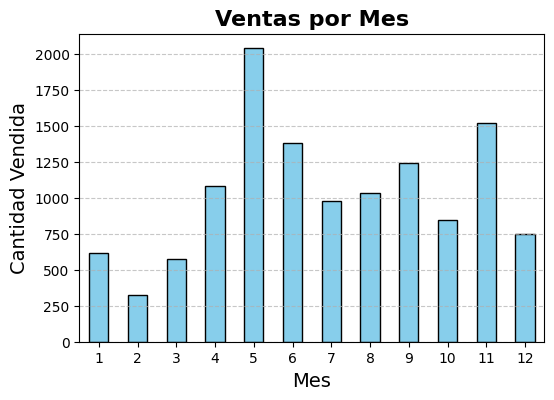

In [37]:
ventas_por_mes = sales.groupby('MES')['CANTIDAD'].sum()

plt.figure(figsize=(6, 4))
ventas_por_mes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Ventas por Mes', fontsize=16, fontweight='bold')
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



## Adapto el dataset para analizar tanto patrones semanales como mensuales. El objetivo es trabajar con la predicción por período de tiempo y agrupar las ventas por un intervalo de tiempo y producto

In [38]:
# Agregar columna de EVENTO
sales['EVENTO'] = sales['MES'].apply(
    lambda x: 'Hot Sale' if x == 5 else ('CyberMonday' if x == 11 else 'Estandar')
)

# Agrupar por 'COD. PRODUCTO', 'AÑO', y 'MES', sumando las cantidades vendidas ('CANTIDAD_TOTAL')
sales_grouped = sales.groupby(['AÑO', 'MES', 'PRODUCTO', 'EVENTO', 'COD. PRODUCTO']).agg(
    CANTIDAD_TOTAL=('CANTIDAD', 'sum')  # Sumamos las cantidades vendidas por mes y producto
).reset_index()
# Verificar que los productos sin ventas estén con CANTIDAD_TOTAL = 0
sales.sample(10)

,FECHA COMPRA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD,AÑO,MES,EVENTO
6445,2023-07-18,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,0.0,CHUBUT,Puerto Madryn,mercadolibre,2,2023,7,Estandar
8190,2022-04-26,1-11-11-017,COLCHÓN L. ATENAS TRADICIONAL 160CMX200CM,0.0,BUENOS AIRES,VILLA MERCEDES,megatone,1,2022,4,Estandar
2238,2022-03-01,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,BUENOS AIRES,Wilde,mercadolibre,1,2022,3,Estandar
7225,2021-07-22,1-12-40-002,COLCHÓN L. ROMA TRADICIONAL 80CMX190CM,5.0,SAN JUAN,SAN JUAN,megatone,1,2021,7,Estandar
3875,2022-11-02,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,RÍO NEGRO,El Bolsón,mercadolibre,1,2022,11,CyberMonday
127,2023-05-09,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,BUENOS AIRES,Quilmes Oeste,fravega,2,2023,5,Hot Sale
7829,2022-01-22,1-10-01-001,ALMOHADAS L.COPO 70CM,0.0,CAPITAL FEDERAL,CAPITAL FEDERAL,megatone,2,2022,1,Estandar
3356,2022-09-10,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,ENTRE RÍOS,Concepción del Uruguay,mercadolibre,1,2022,9,Estandar
4191,2022-11-29,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,SANTA CRUZ,Las Heras,mercadolibre,1,2022,11,CyberMonday
4363,2022-12-24,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,SAN JUAN,San Juan,mercadolibre,1,2022,12,Estandar


In [39]:
# Asegúrate de que la columna 'FECHA_COMPRA' esté en formato datetime
sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], format='%d-%m-%Y')

# Ordenar el dataset por fecha (AÑO, MES)
sales = sales.sort_values(by='FECHA COMPRA', ascending=True)

# Obtener el primer y último mes con sus respectivos años
primer_mes = sales['FECHA COMPRA'].min()
ultimo_mes = sales['FECHA COMPRA'].max()

# Mostrar el primer y último mes con año
print(f"Primer mes registrado: {primer_mes.strftime('%B %Y')}")
print(f"Último mes registrado: {ultimo_mes.strftime('%B %Y')}")

Primer mes registrado: October 2002
Último mes registrado: January 2024


In [40]:
cod_productos_unicos = sales['COD. PRODUCTO'].unique()
print(f"TODOS LOS COD. PRODUCTO: {cod_productos_unicos}")

# Contar cuántos COD. PRODUCTO únicos existen
num_cod_productos_unicos = len(sales['COD. PRODUCTO'].unique())

# Mostrar el resultado
print(f"Cantidad de COD. PRODUCTO únicos: {num_cod_productos_unicos}")


TODOS LOS COD. PRODUCTO: ['1-12-40-006' '1-12-40-003' '1-12-40-002' '1-10-05-002' '1-10-03-002'
 '1-10-03-001' '1-11-06-002' '1-10-04-002' '1-10-05-001' '1-20-20-200'
 '1-12-30-006' '1-14-15-002' '1-12-40-004' '1-14-11-017' '1-11-06-006'
 '1-11-12-006' '1-14-11-006' '1-11-06-004' '1-11-11-017' '1-11-11-006'
 '1-15-40-006' '1-12-27-006' '1-12-27-018' '1-10-01-001' '1-10-02-001'
 '1-10-01-002' '1-11-06-003' '1-12-36-002' '1-22-41-002' '1-15-36-006'
 '1-15-37-019' '1-10-02-002' '1-11-16-017' '1-11-02-002' '1-15-38-019'
 '1-14-11-019' '1-11-06-005' '1-12-27-002' '1-12-38-017' '1-11-17-017'
 '1-11-16-002' '1-14-17-019' '1-11-02-06' '1-14-17-018' '1-22-41-003'
 '1-14-17-017' '1-12-37-002' '1-15-38-006' '1-11-12-017' '1-15-40-004'
 '1-15-38-018' '1-11-11-018' '1-12-37-019' '1-11-08-002' '1-15-27-018'
 '1-14-11-018' '1-23-16-001' '1-12-27-017' '1-14-16-002' '1-11-08-003'
 '1-11-12-018' '1-23-37-004' '1-14-07-006' '1-14-10-019' '1-11-07-006'
 '1-15-40-003' '1-23-36-006' '1-13-32-006' '1-11-10-0

In [41]:
sales.sample(10)

,FECHA COMPRA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD,AÑO,MES,EVENTO
5202,2023-04-24,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,BUENOS AIRES,Darregueira,mercadolibre,1,2023,4,Estandar
723,2023-09-28,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,0.0,BUENOS AIRES,Berisso,fravega,1,2023,9,Estandar
10387,2023-05-08,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,4.0,ENTRE RÍOS,Avenida Ejercito Parana,megatone,1,2023,5,Hot Sale
2842,2022-06-14,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,BUENOS AIRES,Luján,mercadolibre,1,2022,6,Estandar
2285,2022-03-18,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,ENTRE RÍOS,Bovril,mercadolibre,1,2022,3,Estandar
9611,2022-11-04,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,4.0,BUENOS AIRES,VILLA GESELL,megatone,1,2022,11,CyberMonday
4572,2023-02-08,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,NEUQUÉN,Picún Leufú,mercadolibre,1,2023,2,Estandar
205,2023-06-10,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,BUENOS AIRES,Munro,fravega,1,2023,6,Estandar
8728,2022-07-09,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,0.0,SANTA FE,SANTA FE,megatone,1,2022,7,Estandar
4219,2022-12-03,1-11-16-017,ALMOHADAS M.COPO 90CM,0.0,BUENOS AIRES,Quilmes,mercadolibre,1,2022,12,Estandar


In [42]:
sales.shape

(11088, 11)

In [43]:
# Crear un DataFrame con todas las combinaciones posibles de AÑO, MES y COD. PRODUCTO
# Primero obtenemos todos los valores únicos de 'AÑO', 'MES', y 'COD. PRODUCTO'
años = sales['AÑO'].unique()
meses = sales['MES'].unique()
cod_productos_unicos = sales['COD. PRODUCTO'].unique()

# Crear todas las combinaciones posibles (todos los productos por cada año y mes)
combinaciones = pd.MultiIndex.from_product([años, meses, cod_productos_unicos], names=['AÑO', 'MES', 'COD. PRODUCTO'])

# Crear un DataFrame con estas combinaciones
combinaciones_df = pd.DataFrame(index=combinaciones).reset_index()

# Agrupar el dataset original para obtener las ventas totales
sales_grouped = sales.groupby(['AÑO', 'MES', 'COD. PRODUCTO'], as_index=False).agg(
    CANTIDAD_TOTAL=('CANTIDAD', 'sum'),
    PRODUCTO=('PRODUCTO', 'first'),
    EVENTO=('EVENTO', 'first')
)

# Merge con las combinaciones para obtener el valor 0 para los productos no vendidos
sales_final = pd.merge(combinaciones_df, sales_grouped, on=['AÑO', 'MES', 'COD. PRODUCTO'], how='left')

sales_final['CANTIDAD_TOTAL'] = sales_final['CANTIDAD_TOTAL'].fillna(0)
# Merge con las combinaciones para obtener el valor 0 para los productos no vendidos
sales_final = pd.merge(combinaciones_df, sales_grouped, on=['AÑO', 'MES', 'COD. PRODUCTO'], how='left')

In [44]:
sales_final.sample(15)

,AÑO,MES,COD. PRODUCTO,CANTIDAD_TOTAL,PRODUCTO,EVENTO
1867,2021,9,1-10-03-001,NaN,NaN,NaN
4869,2024,12,1-13-32-006,NaN,NaN,NaN
311,2002,5,1-11-06-004,NaN,NaN,NaN
3785,2023,4,1-23-37-004,1.0,PROMO 2 CONJUNTOS L. VASARI TRADICIONAL 80CMX1...,Estandar
2986,2022,8,1-12-37-002,NaN,NaN,NaN
482,2002,6,1-23-05-002,NaN,NaN,NaN
4661,2023,3,1-14-11-018,NaN,NaN,NaN
1247,2021,10,1-11-17-018,NaN,NaN,NaN
5678,2024,1,1-23-15-003,NaN,NaN,NaN
3340,2022,2,1-10-05-001,2.0,ALMOHADAS L.VISCOÉLASTICA 70CM,Estandar


In [45]:
sales_final['EVENTO'] = sales_final['MES'].apply(
    lambda x: 'Hot Sale' if x == 5 else ('CyberMonday' if x == 11 else 'Estandar')
)

sales_final['CANTIDAD_TOTAL'] = sales_final['CANTIDAD_TOTAL'].apply(
    lambda x: 0 if pd.isna(x) else x
)

# Eliminar filas donde 'AÑO' sea 2024 y 'MES' sea mayor o igual a 3
sales_final = sales_final[~((sales_final['AÑO'] == 2024) & (sales_final['MES'] >= 3))]

sales_rename = sales[['COD. PRODUCTO', 'PRODUCTO']].rename(columns={'PRODUCTO': 'DESC_PRODUCTO'})
# Realizar el merge sin crear columnas duplicadas
sales_final = pd.merge(sales_final, sales_rename, on='COD. PRODUCTO', how='left')

In [46]:
sales_final.sample(10)

,AÑO,MES,COD. PRODUCTO,CANTIDAD_TOTAL,PRODUCTO,EVENTO,DESC_PRODUCTO
107896,2002,1,1-11-16-017,0.0,NaN,Estandar,ALMOHADAS M.COPO 90CM
21231,2002,12,1-11-08-003,0.0,NaN,Estandar,COLCHÓN L. PEKIN TRADICIONAL 90CMX190CM
250009,2021,2,1-20-20-200,0.0,NaN,Estandar,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM
155411,2021,4,1-12-40-006,0.0,NaN,Estandar,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM
535087,2024,1,1-20-20-200,121.0,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,Estandar,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM
318008,2022,6,1-11-16-017,322.0,ALMOHADAS M.COPO 90CM,Estandar,ALMOHADAS M.COPO 90CM
228821,2021,11,1-10-01-002,9.0,ALMOHADAS L.COPO 80CM,CyberMonday,ALMOHADAS L.COPO 80CM
62001,2002,7,1-15-40-006,0.0,NaN,Estandar,CONJUNTO L. ROMA TRADICIONAL 140CMX190CM
223546,2021,11,1-20-20-200,313.0,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,CyberMonday,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM
377847,2022,2,1-12-40-003,3.0,COLCHÓN L. ROMA TRADICIONAL 90CMX190CM,Estandar,COLCHÓN L. ROMA TRADICIONAL 90CMX190CM


### Tendencias de mi nuevo data set

#### Evolución de ventas mensuales generales. Se grafica la evolución de las ventas totales en todos los productos. 

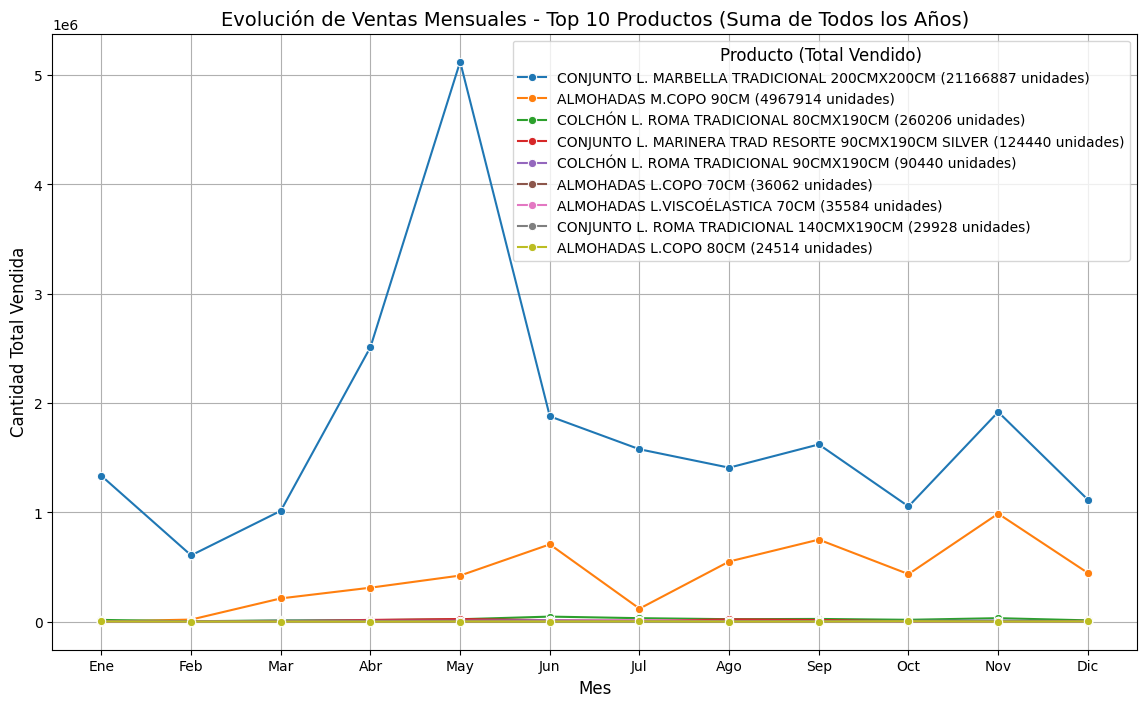

In [47]:
top_productos = sales_final.groupby("COD. PRODUCTO")["CANTIDAD_TOTAL"].sum().nlargest(10).index
ventas_top_productos = sales_final[sales_final["COD. PRODUCTO"].isin(top_productos)]

# Obtengo el nombre del producto correspondiente a cada código
mapa_productos = ventas_top_productos[['COD. PRODUCTO', 'PRODUCTO']].drop_duplicates().set_index('COD. PRODUCTO')['PRODUCTO'].to_dict()
ventas_top_productos.loc[:, 'PRODUCTO'] = ventas_top_productos['COD. PRODUCTO'].map(mapa_productos)

# Agrupo sumando ventas totales por mes y ordeno los productos por cantidad total de ventas
ventas_top_productos = ventas_top_productos.groupby(['MES', 'PRODUCTO'])['CANTIDAD_TOTAL'].sum().reset_index()
total_ventas_por_producto = ventas_top_productos.groupby("PRODUCTO")["CANTIDAD_TOTAL"].sum().sort_values(ascending=False)
productos_ordenados = total_ventas_por_producto.index

plt.figure(figsize=(14,8))
sns.lineplot(data=ventas_top_productos, x="MES", y="CANTIDAD_TOTAL", hue="PRODUCTO", marker="o", palette="tab10", hue_order=productos_ordenados)

handles, labels = plt.gca().get_legend_handles_labels()
nuevas_labels = [f"{prod} ({int(total_ventas_por_producto[prod])} unidades)" for prod in labels]
plt.legend(handles, nuevas_labels, title="Producto (Total Vendido)", fontsize=10, title_fontsize=12)

# etiquetas
plt.title("Evolución de Ventas Mensuales - Top 10 Productos (Suma de Todos los Años)", fontsize=14)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Cantidad Total Vendida", fontsize=12)
plt.xticks(range(1,13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.grid()

plt.show()

## Matriz de correlación

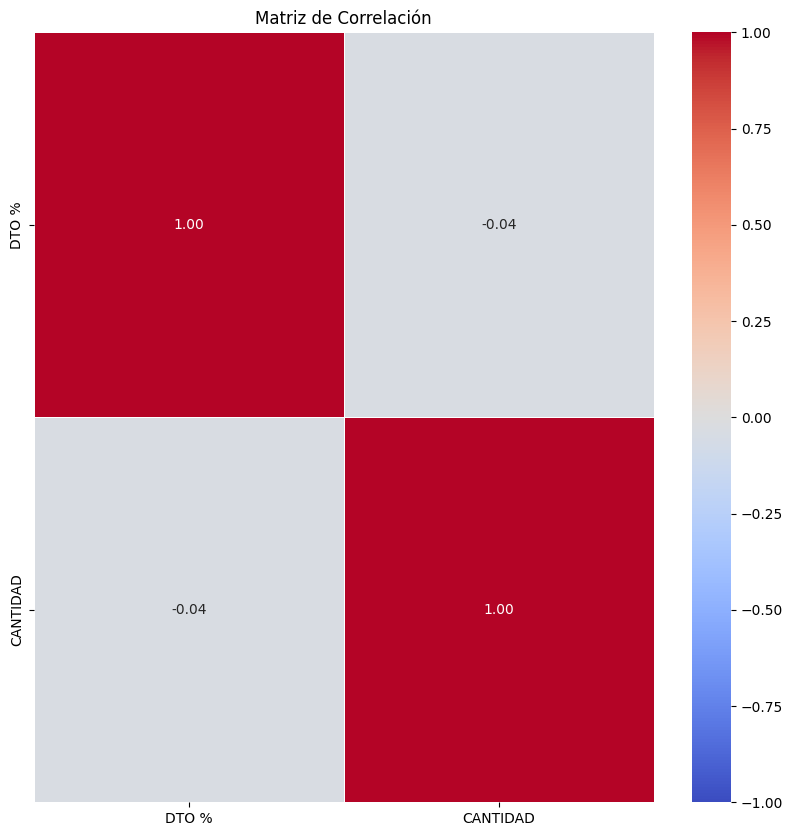

In [48]:
# Seleccionamos las variables numéricas (esto incluye las nuevas columnas de One Hot Encoding)
variables_numericas_ampliadas = sales.select_dtypes(include=['float64', 'int64'])

correlacion_ampliada = variables_numericas_ampliadas.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlacion_ampliada, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Agregar título y etiquetas
plt.title("Matriz de Correlación", fontsize=12)
plt.show()




Podemos observar que: 

CANTIDAD_TOTAL:
- No parece haber una relación significativa entre la cantidad vendida y el descuento promedio aplicado, lo cual es interesante. Esto podría sugerir que el descuento no es un factor determinante para el volumen de ventas, o bien que otras variables más relevantes influyen en las ventas.
- La CANTIDAD_TOTAL está levemente correlacionada con las plataformas. Esto podría indicar que ciertas plataformas (como ecommerce y mercadolibre) podrían tener una mayor cantidad de ventas.

DTO_PROMEDIO:
- Hay una pequeña correlación positiva (0.29) entre el descuento promedio y megatone, lo que sugiere que cuando los productos de megatone tienen mayores descuentos, las ventas aumentan, aunque no sea una relación muy fuerte.
- Hay una relación negativa bastante fuerte (-0.68) entre el descuento promedio y mercadolibre. Esto podría implicar que cuando los descuentos en mercadolibre son mayores, las ventas no aumentan de manera tan significativa, o los productos con mayores descuentos pueden tener menos demanda en esta plataforma.
  


# Hipótesis sobre los datos

## Hipotesis 1: 

#### Comparación de ventas promedio en meses normales vs. eventos

In [49]:
ventas_por_evento = sales_final.assign(
    TIPO_MES = sales_final['MES'].apply(
        lambda x: 'Hot Sale' if x == 5 else ('CyberMonday' if x == 11 else 'Mes Normal')
    )
)

ventas_por_evento = ventas_por_evento.groupby("TIPO_MES")["CANTIDAD_TOTAL"].mean().reset_index()

from IPython.display import display
display(ventas_por_evento)


,TIPO_MES,CANTIDAD_TOTAL
0,CyberMonday,68.528770
1,Hot Sale,127.719765
2,Mes Normal,39.891056


##### Los meses con Hot Sale y CyberMonday tienen ventas superiores a los meses normales.

* En meses normales, se venden en promedio 33.5 unidades de un producto por mes.
* Durante CyberMonday, este número aumenta a 54.82.
* En Hot Sale, la cantidad promedio sube aún más a 102.17.
  
##### Hot Sale parece generar un mayor impacto en las ventas que CyberMonday.

* El aumento en Hot Sale es mayor que en CyberMonday.
* Esto podría deberse a que mayo (Hot Sale) tiene más días promocionales, o a que hay una mayor demanda en ese momento del año

##### Calculamos el porcentaje de aumento en ventas en estos eventos:

* Hot Sale vs. Mes Normal: Hubo un aumento del 204.99% en las ventas durante Hot Sale en comparación con los meses normales.

* CyberMonday vs. Mes Normal: Hubo un aumento del 63.64% en las ventas durante CyberMonday en comparación con los meses normales.

#### Conclusión
✔ Confirmamos la hipótesis: Hot Sale y CyberMonday aumentan significativamente las ventas.

✔ El impacto es mayor en Hot Sale (≈ 204.99% más ventas), que en CyberMonday (≈ 63.64% más ventas).

# Modelado

### Elección de la métrica de performance a utilizar para evaluar los modelos y fundamentación.

Para evaluar el desempeño de los modelos de regresión desarrollados para predecir la cantidad de productos vendidos, es fundamental elegir una métrica que refleje de manera fiel el error de predicción en el contexto del negocio.

En este caso, la variable objetivo (cantidad de productos vendidos) presenta una distribución altamente desbalanceada: la mayoría de los valores son bajos y existen pocos valores atípicos (ventas inusualmente altas). Por este motivo, se selecciona el **Error Absoluto Medio (MAE, Mean Absolute Error)** como métrica principal de evaluación.

El MAE representa el error promedio absoluto entre las predicciones y los valores reales, expresado en las mismas unidades que la variable objetivo. Esta métrica es especialmente adecuada en contextos donde:
 - La mayoría de los valores son bajos y los outliers no deben dominar la evaluación.
 - Se busca una interpretación sencilla y directa del error promedio, fácilmente comunicable a áreas de negocio.
 - Se desea evitar que unos pocos errores grandes (outliers) distorsionen la percepción del desempeño general del modelo.

Complementariamente, se reporta la Raíz del Error Cuadrático Medio (RMSE), que penaliza más fuertemente los errores grandes y puede ser útil para identificar el impacto de los outliers. Sin embargo, la métrica principal para comparar y seleccionar modelos será el MAE, ya que refleja mejor el comportamiento típico del modelo en la mayoría de los casos reales de predicción de ventas

### Próximo paso será entrenar y evaluar diversos algoritmos, realizando una exploración de hiperparámetros mediante una búsqueda en cuadrícula (grid search). Posteriormente, se evaluará el comportamiento de cada modelo utilizando los hiperparámetros que den los mejores resultados, proporcionando conclusiones sobre la comparación entre ellos.

In [50]:
#Elimino los dos registros outliers con data (seguramente mal cargada) del 2002
sales_final = sales_final[sales_final['AÑO'] != 2002]
sales_final = sales_final.drop(columns=[ "PRODUCTO"])

In [51]:
sales_final['AÑO'] = pd.to_numeric(sales_final['AÑO'], errors='coerce')
sales_final['MES'] = pd.to_numeric(sales_final['MES'], errors='coerce')

# Creo una columna de fecha combinando AÑO, MES y un día fijo (el primer día del mes) y Formatear la fecha a DD-MM-YYYY
sales_final['FECHA_COMPRA'] = pd.to_datetime(sales_final['AÑO'].astype(str) + '-' + sales_final['MES'].astype(str) + '-1', format='%Y-%m-%d')
sales_final['FECHA_COMPRA'] = sales_final['FECHA_COMPRA'].dt.strftime('%d-%m-%Y')

# Ordeno el dataset por la nueva columna 'FECHA_COMPRA'
sales_final = sales_final.sort_values(by='FECHA_COMPRA', ascending=True)

sales_final.head()

,AÑO,MES,COD. PRODUCTO,CANTIDAD_TOTAL,EVENTO,DESC_PRODUCTO,FECHA_COMPRA
232848,2021,1,1-12-40-006,0.0,Estandar,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,01-01-2021
236548,2021,1,1-20-20-200,0.0,Estandar,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,01-01-2021
236547,2021,1,1-20-20-200,0.0,Estandar,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,01-01-2021
236546,2021,1,1-20-20-200,0.0,Estandar,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,01-01-2021
236545,2021,1,1-20-20-200,0.0,Estandar,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,01-01-2021


In [52]:
# Asegúrate de que 'FECHA_COMPRA' esté en formato datetime
sales_final['FECHA_COMPRA'] = pd.to_datetime(sales_final['FECHA_COMPRA'], format='%d-%m-%Y')

# Ordenar por la columna 'FECHA_COMPRA'
sales_final = sales_final.sort_values(by='FECHA_COMPRA', ascending=True)

sales_final.head(10)

,AÑO,MES,COD. PRODUCTO,CANTIDAD_TOTAL,EVENTO,DESC_PRODUCTO,FECHA_COMPRA
232848,2021,1,1-12-40-006,0.0,Estandar,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,2021-01-01
243932,2021,1,1-23-16-003,0.0,Estandar,PROMO 2 COLCHONES L.REMBRANDT 100CMX190XM,2021-01-01
243931,2021,1,1-23-16-003,0.0,Estandar,PROMO 2 COLCHONES L.REMBRANDT 100CMX190XM,2021-01-01
243930,2021,1,1-23-15-007,0.0,Estandar,CONJ DALI TRAD 140X190 + 2 ALM 70,2021-01-01
243929,2021,1,1-23-15-007,0.0,Estandar,CONJ DALI TRAD 140X190 + 2 ALM 70,2021-01-01
243928,2021,1,1-23-15-007,0.0,Estandar,CONJ DALI TRAD 140X190 + 2 ALM 70,2021-01-01
243896,2021,1,1-23-15-007,0.0,Estandar,CONJ DALI TRAD 140X190 + 2 ALM 70,2021-01-01
243927,2021,1,1-23-15-007,0.0,Estandar,CONJ DALI TRAD 140X190 + 2 ALM 70,2021-01-01
243925,2021,1,1-23-15-007,0.0,Estandar,CONJ DALI TRAD 140X190 + 2 ALM 70,2021-01-01
243924,2021,1,1-23-15-007,0.0,Estandar,CONJ DALI TRAD 140X190 + 2 ALM 70,2021-01-01


In [53]:
sales_final.shape

(421344, 7)

In [54]:
sales_final = sales_final.drop_duplicates(subset=['AÑO', 'MES', 'COD. PRODUCTO', 'FECHA_COMPRA'])

In [55]:
sales_final.shape

(3724, 7)

In [56]:
sales_final.head

<bound method NDFrame.head of          AÑO  MES COD. PRODUCTO  CANTIDAD_TOTAL    EVENTO  \
232848  2021    1   1-12-40-006             0.0  Estandar   
243932  2021    1   1-23-16-003             0.0  Estandar   
243930  2021    1   1-23-15-007             0.0  Estandar   
243933  2021    1   1-11-16-018             0.0  Estandar   
243935  2021    1   1-12-37-018             0.0  Estandar   
...      ...  ...           ...             ...       ...   
554239  2024    2   1-14-60-004             0.0  Estandar   
554258  2024    2   1-12-37-017             0.0  Estandar   
554252  2024    2   1-15-61-002             0.0  Estandar   
554253  2024    2   1-23-15-003             0.0  Estandar   
554396  2024    2   1-23-16-003             0.0  Estandar   

                                       DESC_PRODUCTO FECHA_COMPRA  
232848       COLCHÓN L. ROMA TRADICIONAL 140CMX190CM   2021-01-01  
243932     PROMO 2 COLCHONES L.REMBRANDT 100CMX190XM   2021-01-01  
243930             CONJ DALI TRAD

In [57]:

# Dividir el dataset en train, validation y test (60%, 20%, 20%)
train_size = int(0.6 * len(sales_final))  # El 60% del dataset
validation_size = int(0.2 * len(sales_final))  # El 20% del dataset

# Dividir el dataset
train = sales_final[:train_size]
validation = sales_final[train_size:train_size + validation_size]
test = sales_final[train_size + validation_size:]

# Verificar las formas de los datasets
print(train.shape, validation.shape, test.shape)

(2234, 7) (744, 7) (746, 7)


In [58]:
print(train.head(10))
print(validation.head(10))
print(test.head(10))

         AÑO  MES COD. PRODUCTO  CANTIDAD_TOTAL    EVENTO  \
232848  2021    1   1-12-40-006             0.0  Estandar   
243932  2021    1   1-23-16-003             0.0  Estandar   
243930  2021    1   1-23-15-007             0.0  Estandar   
243933  2021    1   1-11-16-018             0.0  Estandar   
243935  2021    1   1-12-37-018             0.0  Estandar   
243766  2021    1   1-14-60-003             0.0  Estandar   
243783  2021    1   1-23-05-002             0.0  Estandar   
243799  2021    1   1-12-37-017             0.0  Estandar   
243791  2021    1   1-23-15-003             0.0  Estandar   
243788  2021    1   1-15-61-002             0.0  Estandar   

                                       DESC_PRODUCTO FECHA_COMPRA  
232848       COLCHÓN L. ROMA TRADICIONAL 140CMX190CM   2021-01-01  
243932     PROMO 2 COLCHONES L.REMBRANDT 100CMX190XM   2021-01-01  
243930             CONJ DALI TRAD 140X190 + 2 ALM 70   2021-01-01  
243933  COLCHÓN L. REMBRANDT TRADICIONAL 180CMX200CM   2

In [59]:
# Eliminar registros con valores NaN en la columna 'CANTIDAD_TOTAL' de manera persistente
train = train.dropna(subset=['CANTIDAD_TOTAL'])
validation = validation.dropna(subset=['CANTIDAD_TOTAL'])
test = test.dropna(subset=['CANTIDAD_TOTAL'])

X_train = train.drop(columns=['CANTIDAD_TOTAL'])  
y_train = train['CANTIDAD_TOTAL']  

X_test = test.drop(columns=['CANTIDAD_TOTAL'])  
y_test = test['CANTIDAD_TOTAL']  

X_validation = validation.drop(columns=['CANTIDAD_TOTAL'])  
y_validation = validation['CANTIDAD_TOTAL']  




In [60]:
mapper = DataFrameMapper([
    (['AÑO', 'MES'], [StandardScaler()]),
    (['COD. PRODUCTO'], [OneHotEncoder(sparse_output=False, handle_unknown='ignore')]),
])
# Ajusto la transformación en X_train
X_train_transformed = mapper.fit_transform(X_train)

X_test_transformed = mapper.transform(X_test)
X_validation_transformed = mapper.transform(X_validation)

C:\Users\bosch\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


In [61]:
# Defino una función para evaluar el rendimiento de los modelos
def evaluate_models(X_train, y_train, X_test, y_test, models, model_params=None):
    results = {}
    for model_name, model in models.items():
        print(f"Evaluando el modelo: {model_name}")
        
        # Si se pasan parámetros para GridSearch, realizamos la búsqueda
        if model_params and model_name in model_params:
            grid_search = GridSearchCV(estimator=model, param_grid=model_params[model_name], cv=3, scoring='neg_mean_squared_error', verbose=1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
        else:
            best_model = model
            best_model.fit(X_train, y_train)
        
        # Predicciones
        y_pred_test = best_model.predict(X_test)
        
        # Calcular métricas
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)
        
        results[model_name] = {
            'RMSE': rmse_test,
            'MAE': mae_test,
            'R2': r2_test
        }
        print(f"RMSE en test para {model_name}: {rmse_test:.4f}")
        print(f"MAE en test para {model_name}: {mae_test:.4f}")
        print("-" * 40)
    
    return results


### Entrenamiento modelo Regresion Lineal

In [62]:

# Defino el modelo de regresión lineal
lr_clasif = LinearRegression()
lr_clasif.fit(X_train_transformed, y_train)
y_pred_test = lr_clasif.predict(X_test_transformed)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE en test: {rmse_test:.4f}")
print(f"MAE en test: {mae_test:.4f}")

RMSE en test: 15.4941
MAE en test: 7.9513


### Entrenamiento modelo RIDGE

In [63]:
ridge_model = Ridge()
parameters = {
    'alpha': [0.01, 0.1, 1, 10, 50, 100],  
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']  
}
grid_search_ridge = GridSearchCV(estimator=ridge_model, param_grid=parameters, cv=2, scoring='neg_mean_squared_error', verbose=1)
grid_search_ridge.fit(X_train_transformed, y_train)
best_ridge_model = grid_search_ridge.best_estimator_
print("Mejores parámetros Ridge:", grid_search_ridge.best_params_)

y_pred_ridge = best_ridge_model.predict(X_test_transformed)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)


print(f"RMSE en test (Ridge): {rmse_ridge:.4f}")
print(f"MAE en test (Ridge): {mae_ridge:.4f}")


Fitting 2 folds for each of 30 candidates, totalling 60 fits
Mejores parámetros Ridge: {'alpha': 50, 'solver': 'saga'}
RMSE en test (Ridge): 14.8646
MAE en test (Ridge): 8.3846


### Entrenamiento modelo LASSO

In [64]:
lasso_model = Lasso()
parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_search_lasso = GridSearchCV(estimator=lasso_model, param_grid=parameters, cv=2, scoring='neg_mean_squared_error', verbose=1)
grid_search_lasso.fit(X_train_transformed, y_train)
best_lasso_model = grid_search_lasso.best_estimator_
print("Mejores parámetros Lasso:", grid_search_lasso.best_params_)

y_pred_lasso = best_lasso_model.predict(X_test_transformed)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

print(f"RMSE en test (Lasso): {rmse_lasso:.4f}")
print(f"MAE en test (Lasso): {mae_lasso:.4f}")


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Mejores parámetros Lasso: {'alpha': 10}
RMSE en test (Lasso): 14.8977
MAE en test (Lasso): 4.3655


### Entrenamiento modelo ÁRBOL DE DECISIÓN 

In [65]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_params = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=dt_params, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_dt.fit(X_train_transformed, y_train)
best_dt_model = grid_search_dt.best_estimator_
print("Mejores parámetros para Árbol de Decisión:", grid_search_dt.best_params_)

y_pred_dt = best_dt_model.predict(X_test_transformed)
rmse_test_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mae_dt = mean_absolute_error(y_test, y_pred_dt)

print(f"RMSE en test (Árbol de Decisión): {rmse_test_dt:.4f}")
print(f"MAE en test (Árbol de Decisión): {mae_dt:.4f}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Mejores parámetros para Árbol de Decisión: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
RMSE en test (Árbol de Decisión): 29.2274
MAE en test (Árbol de Decisión): 5.3181


### Entrenamiento modelo RANDOM FOREST

In [66]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [50, 75, 100, 150], 
    'max_depth': [None, 2, 5, 8, 10],  
    'min_samples_split': [5, 10, 15], 
    'min_samples_leaf': [1, 2],  
    'bootstrap': [True, False] 
}
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=rf_params, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_rf.fit(X_train_transformed, y_train)
best_rf_model = grid_search_rf.best_estimator_
print("Mejores parámetros para Random Forest:", grid_search_rf.best_params_)

y_pred_rf = best_rf_model.predict(X_test_transformed)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"RMSE en test (Random Forest): {rmse_test_rf:.4f}")
print(f"MAE en test (Random Forest): {mae_rf:.4f}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Mejores parámetros para Random Forest: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 75}
RMSE en test (Random Forest): 27.7574
MAE en test (Random Forest): 5.1754


### Resultado evaluación modelos con el DataSet original

1- **Regresión Lineal: MAE: 7.95** – El modelo de regresión lineal mostró un rendimiento aceptable, aunque su error absoluto promedio es relativamente alto. Esto indica que el modelo logra captar parcialmente la relación entre las variables de entrada y la cantidad de productos vendidos, pero no es el más preciso para este conjunto de datos.

2- **Ridge Regression: MAE: 8.38** – El modelo Ridge, que incorpora regularización para evitar el sobreajuste, obtuvo un MAE similar al de la regresión lineal. Si bien la regularización ayuda a estabilizar el modelo, en este caso no logró una mejora significativa en la precisión de las predicciones.

3- **Lasso Regression: MAE: 4.37** – El modelo Lasso fue el que presentó el menor error absoluto promedio, lo que sugiere que la selección de características y la regularización aplicada por Lasso permitieron mejorar la capacidad predictiva y reducir la complejidad del modelo. Por este motivo, Lasso se destaca como el mejor modelo entre los evaluados.

4- **Árbol de Decisión: MAE: 5.32** – El árbol de decisión mostró un error promedio menor que los modelos lineales, pero su RMSE y R² indican que el modelo puede estar sobreajustando o no generalizando bien. Esto es común en árboles de decisión cuando no se ajustan correctamente los hiperparámetros o cuando los datos presentan alta variabilidad.

5- **Random Forest: MAE: 5.18** – El modelo Random Forest, aunque robusto y generalmente efectivo, en este caso no superó al modelo Lasso. Su desempeño sugiere que, a pesar de combinar múltiples árboles, el modelo no logra capturar adecuadamente la complejidad de los datos, posiblemente debido a la alta dispersión y desbalance en la variable objetivo.

### Conclusión
El modelo Lasso Regression fue el que obtuvo el menor MAE, por lo que se elige como el mejor modelo para este problema. Decido utilizar el MAE como métrica principal de evaluación porque refleja de manera más representativa el error típico de predicción en mi contexto de ventas, donde hay alta dispersión y presencia de outliers.

### Transformación del Dataset en busca de mejoras en los resultados

In [67]:
sales_transformed = sales_final.copy()
sales_transformed['CANTIDAD_TOTAL'] = np.log1p(sales_transformed['CANTIDAD_TOTAL'])

train_transf, not_train_transf = train_test_split(sales_transformed, test_size=0.4, random_state=42)
validation_transf, test_transf = train_test_split(not_train_transf, test_size=0.5, random_state=42)

X_train_transf = train_transf.drop(columns=['CANTIDAD_TOTAL']) 
y_train_transf = train_transf['CANTIDAD_TOTAL'] 

X_validation_transf = validation_transf.drop(columns=['CANTIDAD_TOTAL'])  
y_validation_transf = validation_transf['CANTIDAD_TOTAL']  

X_test_transf = test_transf.drop(columns=['CANTIDAD_TOTAL'])  
y_test_transf = test_transf['CANTIDAD_TOTAL']  

mapper_transf = DataFrameMapper([    
    (['AÑO', 'MES'], [StandardScaler()]),    
    (['COD. PRODUCTO'], [OneHotEncoder(sparse_output=False, handle_unknown='ignore')]),
])

X_train_transformed = mapper_transf.fit_transform(X_train_transf)
X_validation_transformed = mapper_transf.transform(X_validation_transf)
X_test_transformed = mapper_transf.transform(X_test_transf)


C:\Users\bosch\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


#### Evaluación modelo REGRESIÓN LINEAL

In [68]:
# Modelos a evaluar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Hiperparámetros para GridSearch (si aplicable)
model_params = {
    'Ridge': {'alpha': [0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.1, 0.01, 0.001, 1]},
    'Decision Tree': {'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4]},
    'Random Forest': {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5], 'min_samples_leaf': [2, 4]}
}

# Evaluar los modelos con los conjuntos de datos transformados
results = evaluate_models(X_train_transformed, y_train_transf, X_test_transformed, y_test_transf, models, model_params)

# Imprimir los resultados
print("Resultados de RMSE y MAE para todos los modelos:")
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE = {metrics['RMSE']:.4f} | MAE = {metrics['MAE']:.4f}")


Evaluando el modelo: Linear Regression
RMSE en test para Linear Regression: 0.7021
MAE en test para Linear Regression: 0.4524
----------------------------------------
Evaluando el modelo: Ridge
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros para Ridge: {'alpha': 1}
RMSE en test para Ridge: 0.7022
MAE en test para Ridge: 0.4574
----------------------------------------
Evaluando el modelo: Lasso
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros para Lasso: {'alpha': 0.001}
RMSE en test para Lasso: 0.7074
MAE en test para Lasso: 0.4710
----------------------------------------
Evaluando el modelo: Decision Tree
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Mejores parámetros para Decision Tree: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2}
RMSE en test para Decision Tree: 0.6868
MAE en test para Decision Tree: 0.4433
----------------------------------------
Evaluando el modelo: Random Forest
Fitt

#### Resultados luego de la transformacion:
* **Regresión Lineal: RMSE: 0.7021 | MAE: 0.4524** - Al aplicar la regresión lineal sobre la variable transformada, obtuve un error promedio bajo, lo que indica que el modelo logra capturar adecuadamente la tendencia general de los datos.
* **Ridge Regression: RMSE: 0.7022 | MAE: 0.4574** - El modelo Ridge, con regularización, mostró un desempeño muy similar al de la regresión lineal. En mi caso, la regularización no aportó una mejora significativa.
* **Lasso Regression: RMSE: 0.7074 | MAE: 0.4710** - El modelo Lasso también tuvo un rendimiento comparable, aunque con un error levemente mayor. Esto sugiere que la selección de características no fue determinante en este contexto.
* **Árbol de Decisión: RMSE: 0.6868 | MAE: 0.4433** - El árbol de decisión logró un error ligeramente menor que los modelos lineales, lo que indica que pudo captar algunas relaciones no lineales presentes en los datos.
* **Random Forest: RMSE: 0.6351 | MAE: 0.4273** - El modelo Random Forest fue el que obtuvo el menor error, tanto en RMSE como en MAE. Esto me indica que la combinación de múltiples árboles permitió capturar mejor la complejidad de los datos y mejorar la precisión de las predicciones.

#### Conclusión
Después de transformar la variable objetivo con logaritmo, todos los modelos mejoraron notablemente su desempeño. El Random Forest se destaca como el mejor modelo, ya que obtuvo el menor MAE y RMSE. Considero que la transformación logarítmica fue clave para estabilizar la varianza y reducir el impacto de los valores atípicos, permitiendo que los modelos generalicen mejor.



#### Análisis:
 - Al analizar los resultados obtenidos tras la transformación logarítmica de la variable objetivo, se notaron varias mejoras importantes respecto a los modelos entrenados con la variable original. En primer lugar, los valores de error (tanto RMSE como MAE) disminuyeron considerablemente, lo que indica que los modelos ahora logran predecir con mayor precisión la cantidad de productos vendidos, al menos en la escala logarítmica.
- Se puede observar que los modelos lineales (Regresión Lineal, Ridge y Lasso) presentan un desempeño muy similar entre sí, lo que sugiere que la relación entre las variables predictoras y la variable objetivo es en gran parte lineal, o que las técnicas de regularización no aportan un valor diferencial significativo en este caso. Sin embargo, los modelos basados en árboles, especialmente el Random Forest, lograron mejorar aún más el error, lo que me indica que existen ciertas relaciones no lineales o interacciones entre variables que estos modelos pueden capturar mejor.
- La diferencia entre RMSE y MAE es ahora mucho menor que en el caso sin transformación, lo que me confirma que la transformación logarítmica ayudó a reducir el impacto de los valores atípicos y a estabilizar la varianza de la variable objetivo. Esto es especialmente relevante en problemas de ventas, donde suelen existir pocos valores muy altos que pueden distorsionar el entrenamiento y la evaluación de los modelos.

En resumen, considero que la transformación logarítmica fue una decisión acertada para este problema, ya que permitió mejorar la capacidad predictiva de los modelos y obtener métricas de error más representativas y estables. Además, la comparación entre diferentes algoritmos me permitió identificar que, en este contexto, el modelo de Random Forest es el que mejor se adapta a la complejidad de los datos.
